<h1>
    <center>
        TMA4320 Prosjekt 2

Formålet med prosjektet er å gi en introduksjon til maskinlæring, nærmere bestemt dyplæring og dype nevrale nettverk, ved egen implementering av algoritmene. 
Ideen er å trene dataprogrammet til å gjenkjenne bildeelementer i to ulike testproblemer. I det første testproblemet er problemstillingen forenklet til gjenkjenning av fargede datapunkt, mens i det andre testproblemet skal programmet kunne skille mellom to ulike håndskrevne sifre. 
Denne rapporten skal først presentere den grunneleggende algoritmen som benyttes i treningsfasen og hovedsaklig er lik for begge problemstillingene, før hver problemstilling blir framstilt i detalj.
Valg av startparametre skal begrunnes og parametrene som ble funnet i treningsfasen skal presenteres. Deretter skal modellen med disse fikserte parametrene kjøres med nye data og resultatene bli lagt fram og diskutert.

Algoritmen er delt inn i ulike funksjoner for å forenkle kodestrukturen. Først blir det laget fire tilfeldige parametere; K vektere $W_{k}$, K bias $b_{k}$, en vektor $\omega$ og en skalar $\mu$. $K$ er totalt antall lag i transformasjonen. Videre blir et bilde $Y_k$ transformert til det neste laget $k+1$ ved hjelp av en vekter, en bias og funksjonen $\sigma (x)$. Når de  $I$ bildene har blitt transformert gjennom alle lagene blir hver av de projisert ned på en skalar $Z$ ved hjelp av $\omega$, $\mu$ og funksjonen $\eta (x)$. Verdiene for hvert av de $I$ bildene i $Z$ blir sammenliknet med fasitverdiene i $c$, og denne differansen representeres i $J$. For å minimere $J$ finner funksjonen findGradJ de fire gradientene til $J$ med hensyn på de ulike parameterne. Deretter blir vekter og bias oppdatert ved hjelp av "plain vanilla gradient descent" for spiralen og Adam-metoden for siffergjenkjenning for å optimere parameterne. Parameterne blir også lagret i en tekstfil for hver transformasjon gjennom de $K$ lagene. 

In [93]:
import numpy as np
from matplotlib import pyplot as plt
import math
import random 

In [111]:
def trening1(n=1000):
    
    features, labels = read_spiral_from_file()
    W_k, b_k, omega, my = getRandomParam(2, K)
    tau = 0.01
    
    c_vec = labels*1
    Y_k = [features]
       
    for i in range(n):
        Y_k = [features]
        for i in range(W_k.shape[0]):
            Y_next = findNextYMat(Y_k[-1], W_k[i], b_k[i])
            Y_k.append(Y_next)
    
        z_vec = findZvalue(Y_k[-1],omega,my)
    
    #Nå inneholder Y_k ALLE k, dvs at Y_end er med i Y_k, og må derfor skilles ut før Y_k settes inn i 
    #Gradientfunksjonen
    
        J_diff_W, J_diff_b, J_diff_omega, J_diff_my = findGradJ(z_vec,W_k,Y_k[:-1],Y_k[-1],omega,c_vec,my,b_k)
        W_k, b_k, omega, my = U_jPlussEn(W_k,b_k,omega,my,tau,J_diff_W,J_diff_b,J_diff_omega,J_diff_my)
    #print(W_k)
    return(W_k, b_k, omega, my, features, labels)

#Her har vi funnet endelige matriser, vektorer og verdier vi ønsker å bruke 
#på spiralen til slutt
W_k_learned, b_k_learned, omega_learned, my_learned, features_1, labels_1 = trening1()
Y_k_final = [features_1]
J_list1 = [J(findZvalue(Y_k_final[-1], omega_learned, my_learned), labels_1 * 1)]
for i in range(W_k_learned.shape[0]):
    Y_next = findNextYMat(Y_k_final[-1], W_k_learned[i], b_k_learned[i])
    Y_k_final.append(Y_next)
    J_list1.append(J(findZvalue(Y_k_final[-1], omega_learned, my_learned), labels_1 * 1))
#Har nå funnet alle Y også.
Y_k_final = np.array(Y_k_final)


#Definerer andre testsett:
features_2, labels_2 = read_spiral_from_file('spiral_text_file2.txt')
Y_k_final2 = [features_2]
J_list2 = [J(findZvalue(Y_k_final2[-1], omega_learned, my_learned), labels_2 * 1)]
for i in range(W_k_learned.shape[0]):
    Y_next2 = findNextYMat(Y_k_final2[-1], W_k_learned[i], b_k_learned[i])
    Y_k_final2.append(Y_next2)
    J_list2.append(J(findZvalue(Y_k_final2[-1], omega_learned, my_learned), labels_2 * 1))
Y_k_final2 = np.array(Y_k_final2)






In [94]:
#Lager w_k og b_k
def getRandomParam(d=2, K=20):
    w_k=np.random.randn(K,d,d)
    b_k=np.random.randn(K,d)
    omega = np.random.randn(d)
    my = np.random.rand(1)
    return w_k,b_k,omega, my

In [95]:
h = 1
#Definerer konstant for antall lag:
K = 20

#Finner Y_k+1
#Trenger først sigma, aktiveringsfunksjonen
def sigma(x):
    return(np.tanh(x))
#     Dersom vi heller vil bruke max(), nå må x kun være vektor, denne må utvides:
#     Denne er brukt til å teste funksjonene
#     if isinstance(x, (np.ndarray, list)):
#         returliste = []
#         for element in x:
#             returliste.append(max(element, 0))
#         return(np.array(returliste))
#     else:
#         return(max(0, x))

#Sigma derivert analytisk
def sigma_diff(x):
    return(1-np.tanh(x)**2)

def eta(x):
    return(np.exp(x)/(np.exp(x)+1))

#Analytisk løsning av derivasjon av eta
def eta_diff(x):
    return(np.exp(x)/(np.exp(x) + 1)**2)
    
def checkArray(array, string):
    if isinstance(array, list):
        return(np.array(array))
    elif not isinstance(array, np.ndarray):
        raise ValueError(string, "was not an np.ndarray.")
        
#Hjelpefunskjon for å regne ut vektorproduktet V_1@V_2^T
#Denne vil altså returnere en matrise, ikke en skalar størrelse
def makeMatrixFromVec(a, b):
    return_matrix = np.zeros((len(a), len(b)))
    for i in range(len(b)):
        return_matrix[:, i] = b[i]*a
    return(return_matrix)
    
def findNextYVec(Y_k, W_k, b_k):
    #Denne funksjonen skal finne Y_k+1 = Y_k + h sigma(W_k * Y_k + b_k)
    #Y er en matrise (dxI), W er en matrise (dxd) og b er en vektor
    #Her er sigma en skalar funksjon som anvendes komponentvis på vektoren.
    #All input skal være np.ndarrays, men b_k vil være den eneste som lager krøll
    checkArray(b_k, 'b_k')
    # Finner produktet W_k * Y_k og legger til b_k
    vec_for_sigma = np.dot(W_k, Y_k) + b_k
    #Anvender sigma elementvis
    sigma_vec = sigma(vec_for_sigma)
    #Avkommenter for å sjekke at sigma gjør som den skal
    #print(vec_for_sigma)
    #print(sigma_vec)
    return(Y_k+h*sigma_vec)

def findNextYMat(Y_k_mat, W_k, b_k):
    #Shape[1] finner antall kolonner
    #Shape[0] finner antall rader, dvs. samme som len()
    numberOfColumns = Y_k_mat.shape[1]
    nextYMat = np.array([np.array([0.0 for i in range(numberOfColumns)]) for e in range(Y_k_mat.shape[0])])
    for column in range(numberOfColumns):
        Y_k = Y_k_mat[:, column]
        nextYMat[:, column] = findNextYVec(Y_k, W_k, b_k)
    return(np.array(nextYMat))

#Legger ved matrisene jeg har brukt for å sjekke at alt fungerer som det skal
A = np.array([[1, 2], [2, 1]])
Y_k_mat = np.array([np.array([-2, 1, 1]), np.array([1, 1, 1])])
print(findNextYMat(Y_k_mat, A, np.array([1, 1])))
#Her er altså b_k = [1, 1]

#Hjelpefunksjon som vi strengt tatt definerer på nytt senere, men det er denne jeg har brukt i testene
def findZvalue(Y_k_mat, w_vec, my):
    #w og my er konstante mellom alle K-lag, men endres for for iterasjon
    #Skal regne ut eta(Y_k^T * w + my * [1 for i in range(len(w))]
    #n = len(Y_k_mat)
    #d = len(Y_k_mat[0])
    
    #Y_trans = np.array([[Y_k_mat[i,j] for i in range(n)]for j in range(d)])
    vec_for_eta = np.dot(w_vec, Y_k_mat) + my #np.array([my for i in range(Y_k_mat.shape[1])])
    #Kan også regne ut:
    #Y_T = np.transpose(Y_k_mat)
    #vec_for_eta = np.dot(Y_T, w) + np.array([w for i in range(len(w))])
    #print(vec_for_eta)
    return(eta(vec_for_eta))

def findGradJ(Z_vec, W_K, Y_K, Y_end, w_vec, c_vec, my, b_K):
     #Til kodeoptimalisering - et produkt går igjen: eta_diff(Y_K^T * w_vec + my*Vec1)
    prod_to_re_use = eta_diff(np.dot(w_vec, Y_end)+my) #np.array([my for i in range(len(Z_vec))]))
    #Dette kommer egentlig til slutt, men starter der:
    J_diff_my = 0
    for i in range(len(Z_vec)):
        J_diff_my += (Z_vec[i]-c_vec[i])*eta_diff(np.dot(w_vec, Y_end[:, i])+my)
    #dJ/dw  = Y_K * [(Z-c)had*eta_diff(Y_K^T*w + my*1Vec]
    #had* er hadamard-produktet, som bare er å gange sammen alle elementene for seg, 1Vec er en vektor fylt med enere
    diff_my_vec_for_product = np.multiply(Z_vec - c_vec, prod_to_re_use)
    J_diff_w = np.dot(Y_end, diff_my_vec_for_product)
    #Definerer P_K = dJ/dY_K
    #P_K er altså en matrise
    #dJ/dY_K = w_vec * [(Z_vec - c_vec)had*eta_diff(Y_K^T * w_vec + my*Vec1)]^T      NB: Husk transponering
    #Rekursivt:
    #P_k-1: P_k + h*W_k-1^T*[sigma_diff(W_k-1*Y_k-1 + b_k-1)had*P_k)
    P_K = makeMatrixFromVec(w_vec, np.multiply(Z_vec - c_vec, prod_to_re_use))
    #Ønsker nå å samle opp for alle de deriverte k < K:
    P_k_liste = [P_K]
    #Ønsker å lage b_k som en matrise, b_k har samme dimensjon som en kolonne av WdotY, men den må være like lang
    for i in range(K-1, -1, -1):
        #Starter å indeksere fra toppen, fordi W_k og Y_k inneholder k < K
        WdotY = np.dot(W_K[i], Y_K[i])
        b_i_mat = np.array([np.array([b_K[i][j] for e in range(WdotY.shape[1])]) for j in range(WdotY.shape[0])])
        matrix_for_sigma_diff =  WdotY + b_i_mat
        matrix_for_product = np.multiply(sigma_diff(matrix_for_sigma_diff), P_k_liste[0])
        P_i = P_k_liste[0] + h * np.dot(np.transpose(W_K[i]), matrix_for_product)
        P_k_liste.insert(0, P_i)
    #Har nå funnet alle P_k, og kan begynne å regne ut de deriverte.
    J_diff_W_matrix = []
    #dJ/dW_k = h*[P_k+1 *had sigma_diff(W_k*Y_k + b_k)]*Y_k^T
    J_diff_b_vec = []
    #dJ/db_k = h*[P_k+1 *had sigma_diff(W_k*Y_k + b_k)]*
    for j in range(K):
        W_jY_j = np.dot(W_K[j], Y_K[j])
        b_j_mat = np.array([np.array([b_K[j][c] for e in range(W_jY_j.shape[1])]) for c in range(W_jY_j.shape[0])])
        one_vector = np.array([1.0 for e in range(W_jY_j.shape[1])])
        J_diff_W_matrix.append(h*np.dot(P_k_liste[j+1]*sigma_diff(W_jY_j + b_j_mat), np.transpose(Y_K[j])))
        J_diff_b_vec.append(h*np.dot(P_k_liste[j+1]*eta_diff(W_jY_j + b_j_mat), one_vector))
    return(J_diff_W_matrix, J_diff_b_vec, J_diff_w, J_diff_my)

[[-1.23840584  1.9993293   1.9993293 ]
 [ 0.03597242  1.9993293   1.9993293 ]]


In [96]:
#Lager Z
def n(x):
    return (np.exp(x))/(np.exp(x)+1)

def Z(Y_k, w, u, n):
    vec=Y_k.transpose()@w + u*np.ones(((Y_k.transpose()@w).size), dtype=int)
    return n(vec)

#print(Z(Y_k,w,u,n))

In [97]:
#lager J

def J(Z,c):
    return 0.5*np.linalg.norm(Z-c)**2


In [98]:
#lager neste U, dvs. parametrene

def U_jPlussEn(W_k,b_vec,w,my,tau,J_diff_W_matrix, J_diff_b_vec, J_diff_w, J_diff_my):
    W_k = W_k - np.multiply(J_diff_W_matrix,tau)
    b_vec = b_vec - np.multiply(J_diff_b_vec, tau)
    w = w - tau*J_diff_w
    my = my -tau*J_diff_my
    return W_k, b_vec,w,my

In [99]:
#adam descent

                                                                                                                             
def adam(m,v,j,J_diff_W_matrix, J_diff_b_vec, J_diff_w, J_diff_my,W_k,b_vec,w,my):                                           
    beta1 = 0.9                                                                                                              
    beta2 = 0.999                                                                                                            
    alfa = 0.01                                                                                                              
    epsilon = 1E-8                                                                                                           
                                                                                                                             
    G = [J_diff_W_matrix,J_diff_b_vec,J_diff_w,J_diff_my]                                                                    
    U = [W_k,b_vec,w,my]                                                                                                     
                                                                                                                             
    for i in range(len(G)):                                                                                                  
                                                                                                                             
        m = m + (1-beta1)*G[i]                                                                                               
        v = v + (1-beta2)*(g[i]*g[i])                                                                                        
                                                                                                                             
        mj = m/(1-beta1**j)                                                                                                  
        vj = v/(1-beta2**j)                                                                                                  
                                                                                                                             
        U[i] = U[i] - alfa*(mj/(np.sqrt(vj)+epsilon))                                                                        
                                                                                                                             
    return W_k,b_vec,w,my, m,v                                                                                               

In [100]:
def write_spiral_to_file(filename = 'spiral_text_file.txt'):
    features, labels = get_data_spiral_2d()
    try:
        file = open(filename, 'x')
    except FileExistsError:
        file = open(filename, 'w')
    features_0 = ''
    features_1 = ''
    labels_str = ''
    #Itererer gjennom nesten hele datasettet, fordi siste element skal håndteres litt annerledes
    for n in range(len(features[0]) - 1):
        features_0 += str(features[0][n]) + ', '
        features_1 += str(features[1][n]) + ', '
        labels_str += str(labels[n][0]) + ', '
    features_0 += str(features[0][len(features[0]) - 1]) + '\n'
    features_1 += str(features[1][len(features[0]) - 1]) + '\n'
    labels_str += str(labels[len(features[0]) - 1][0]) + '\n'
    print(features_0, features_1, labels_str)
    file.write(features_0)
    file.write(features_1)
    file.write(labels_str)
    file.close()
    
def read_spiral_from_file(filename = 'spiral_text_file.txt'):
    #Denne funksjonen leser en fil som er lagret på formatet fra write_spiral_to_file
    file = open(filename, 'r')
    #Vet at filen lagres med tre linjer
    features_0 = file.readline()
    features_0.strip()
    features_list_0 = features_0.split(', ')
    features_1 = file.readline()
    features_1.strip()
    features_list_1 = features_1.split(', ')
    labels_str = file.readline()
    labels_list = labels_str.split(', ')
    for i in range(len(labels_list)):
        features_list_0[i] = float(features_list_0[i])
        features_list_1[i] = float(features_list_1[i])
        if labels_list[i] == 'True':
            labels_list[i] = True
        else:
            labels_list[i] = False
    return(np.array([features_list_0, features_list_1]), np.array(labels_list))

#write_spiral_to_file('spiral_text_file2.txt')

#features, labels = read_spiral_from_file()
#print(features, labels)

## Inkluderte funksjoner

In [101]:
def get_data_spiral_2d(n_samples=200):
    '''Create "observations" for training.
    
    Creates n_samples dots on two intertwined spirals.
    The dots are classified based on which spiral they belong to and
    then fuzzed by perturbing the coordinates and permuting the ordering.'''
    m1 = math.ceil(n_samples / 2)
    m2 = n_samples - m1
    
    n_turns = 1.0
    
    phi1 = np.pi
    d1 = make_spiral(m1, phi1, n_turns)

    
    phi2 = (phi1 + np.pi) % (2.0 * np.pi)
    d2 = make_spiral(m2, phi2, n_turns)
    
    features = np.hstack((d1, d2))
    labels = np.ones((n_samples,1), dtype='bool_')
    labels[m1:] = False
    
    features = features + .05 * np.random.randn(*features.shape)
    
    indexes = np.random.permutation(n_samples)
    features = features[:, indexes]
    labels = labels[indexes]


    return features, labels
#print(get_data_spiral_2d())

def make_spiral(m, phi, n_turns):
    '''Makes points on a spiral
    
    This is a utility function for get_data_spiral_2d'''
    r = np.linspace(0.1, 1.0, m)
    a = np.linspace(0.1, 2.0 * np.pi * n_turns, m)
    xs = r * np.cos(a + phi)
    ys = r * np.sin(a + phi)
    return np.stack([xs, ys])


In [102]:
'''
This module contains three functions that can plot some aspects of the simple 2d-points-in-a-spiral problem.
The functions can be used as is, without looking into their inner workings.
You can also use them as inspiration for other ways of visualizing what your neural net does.
'''
def forward_function(Y_k_mat, omega, my):
    vec_for_eta = np.dot(omega, Y_k_mat) + my
    return(eta(vec_for_eta))
    
def last_function(Y_K, omega, my): #Tar inn Y_K
    vec_for_eta = np.dot(omega, Y_K) + my
    return(eta(vec_for_eta))


def plot_progression(Y, C):
    '''
    This function should make K+1 plots showing how, as the network progresses through its layers,
    the datapoints are drawn apart in such a way that they can be separated by a straight line.
    
    Y: A K+1-by-I-by-2 matrix of the values for each data point in the training set in each layer.
    C: An I-by-1 matrix of the labels corresponding to the datra points in Y.
    '''
    for k in range(Y.shape[0]):
        show_dots(Y[k,:,:],C.flatten())
        plt.show()


def plot_model(forward_function, Ys, C, n):
    '''
    Make a map that shows what part of the 2d plane is classified as belonging to which spiral arm.
    Also plot the training data in Ys, C.
    
    forward_function: A function that takes one argument, an S-by-2 matrix of S datapoints, and
        returns a vector of S classification values.
        
        Hint: This function will use the weights you have found, so you might want it to be a method on a
        class called something like Network or Model.
    Ys: An I-by-2 matrix. Corresponding to Y[0,:,:]
    C: An I-by-1 matrix of the labels corresponding to the datra points in Ys.
    n: Number of test-points in each direction. This controls the resolution of the plot.
    '''
    grid, coordinates = get_discretization(Ys, n)

    Z = forward_function(grid, omega, my)
    l = np.linspace(0,1,8)
    l = np.array([shading(x) for x in l])

    plot_contours(*coordinates, Z, l, Ys, C.flatten())


def plot_separation(last_function, Ys, C, n):
    '''
    Show how the training data is represented in the last layer. Also maps the rest of the possible points in the plane.
    
    last_function: A function that takes one argument, and S-by-2 matrix of S intermediate states in
        the network, and retruns a vector of S classification values.
        It should multiply by w, add μ and evaluate 𝜂.
        
        Hint: This function will use the weights you have found, so you might want it to be a method on a
        class called something like Network or Model.
    Ys:An I-by-2 matrix. Corresponding to Y[-1,:,:].
    C: An I-by-1 matrix of the labels corresponding to the datra points in Ys.
    n: Number of test-points in each direction. This controls the resolution of the plot.
    '''
    grid, coordinates = get_discretization(Ys, n)

    Z = last_function(grid,)
    l = np.linspace(0,1,500)

    plot_contours(*coordinates, Z, l, Ys, C.flatten())


######## Internals


def show_dots(positions, labels):
    '''Visualize the output of get_data_spiral_2d'''
    plt.scatter(x=positions[0,:], y=positions[1,:], s=1, c=labels, cmap='bwr')
    plt.axis([-1.2, 1.2, -1.2, 1.2])
    plt.axis('square')


def plot_contours(box, xcoordinates, ycoordinates, Z, l, Ys, C1):
    n = xcoordinates.size
    plt.contourf(xcoordinates, ycoordinates, Z.reshape((n,n)), cmap='seismic', levels=l)
    plt.contour(xcoordinates, ycoordinates, Z.reshape((n,n)), levels=1, colors='k')
    plt.scatter(x=Ys[0,:], y=Ys[1,:], s=1, c=C1, cmap='bwr')
    plt.axis(box)
    plt.axis('equal')
    plt.show()


def get_discretization(Ys, n):
    xmin, xmax, ymin, ymax = get_box(Ys)
    xcoordinates = np.linspace(xmin, xmax, n)
    ycoordinates = np.linspace(ymin, ymax, n)
    grid = get_grid(xcoordinates, ycoordinates)
    coordinates = ([xmin, xmax, ymin, ymax], xcoordinates, ycoordinates)
    return grid, coordinates


def get_box(Ys):
    xmin = min(Ys[0,:])
    xmax = max(Ys[0,:])
    xdelta = xmax-xmin
    xmin -= 0.2*xdelta
    xmax += 0.2*xdelta
    ymin = min(Ys[1,:])
    ymax = max(Ys[1,:])
    ydelta = ymax-ymin
    ymin -= 0.2*ydelta
    ymax += 0.2*ydelta
    return xmin, xmax, ymin, ymax

    
def get_grid(xcoordinates, ycoordinates):
    xv, yv = np.meshgrid(xcoordinates, ycoordinates)
    xs = xv.reshape(-1)
    ys= yv.reshape(-1)
    grid = np.stack([xs,ys])
    return grid


def shading(x):
    return shading1(shading2(x))


def shading1(x):
    if x == 0.0:
        return 0.0
    return 0.5 * np.tanh(np.tan(x * np.pi + np.pi / 2.0)) + 0.5


def shading2(x):
    if x < 0.5:
        return 0.5 - np.sqrt(0.25 - x**2)
    else:
        return 0.5 + np.sqrt(0.25 -(x-1.0)**2)


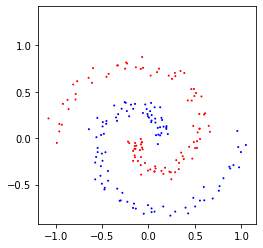

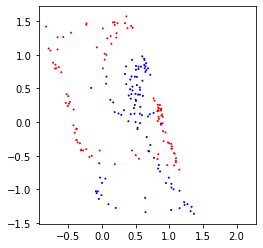

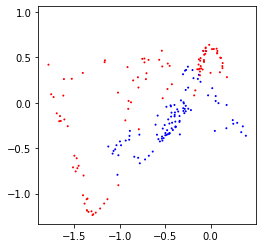

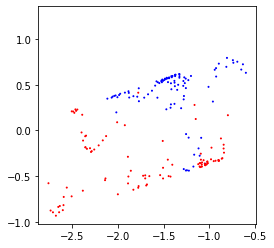

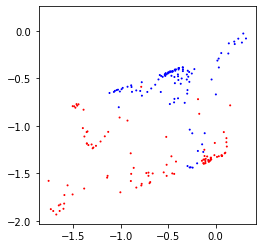

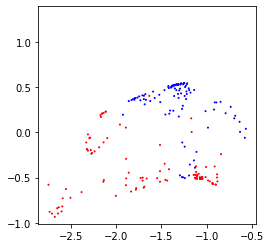

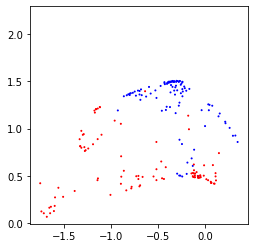

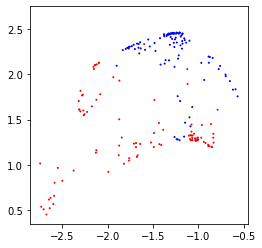

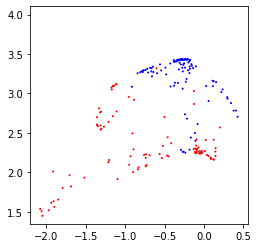

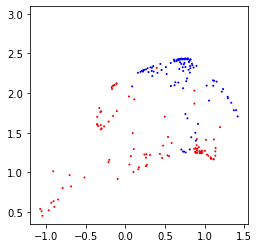

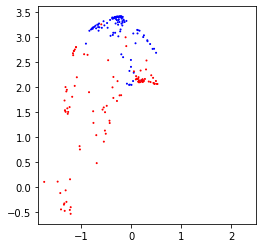

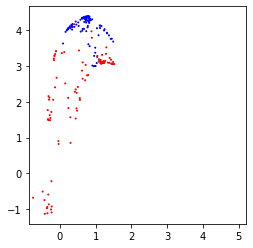

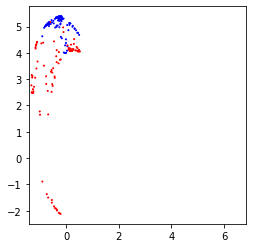

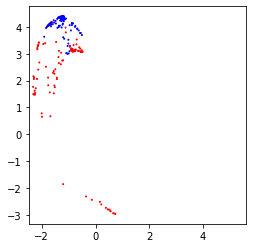

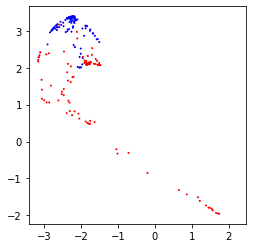

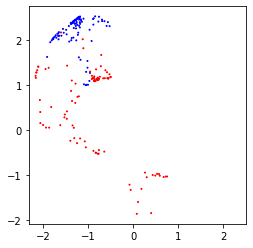

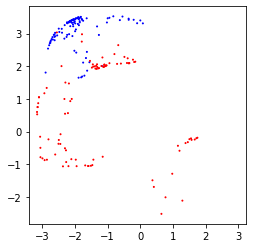

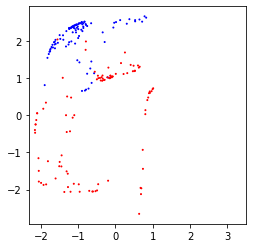

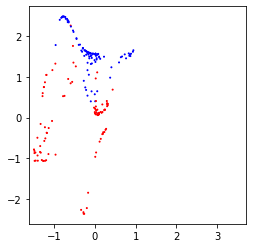

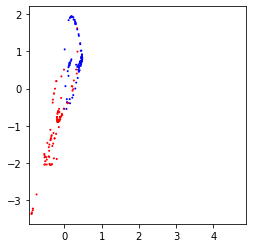

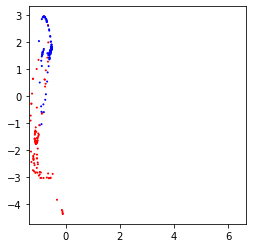

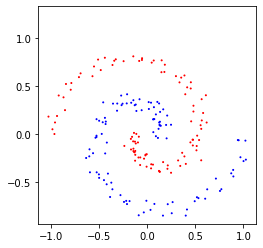

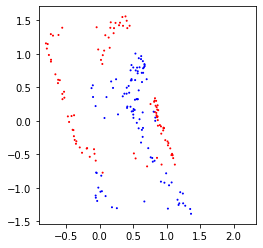

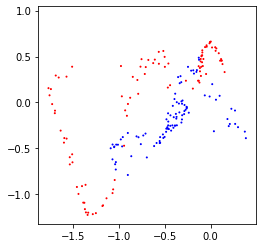

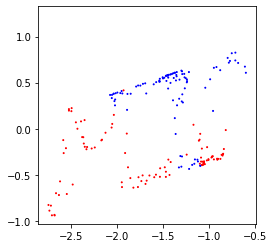

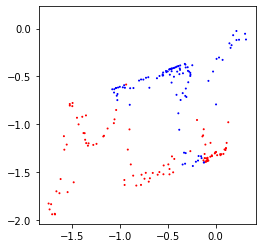

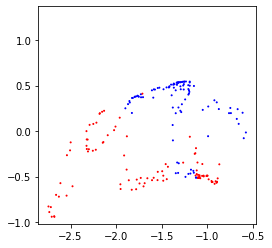

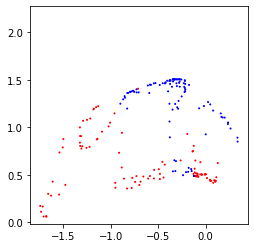

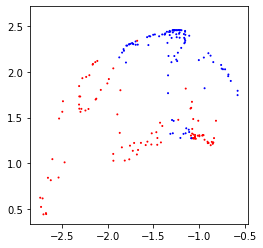

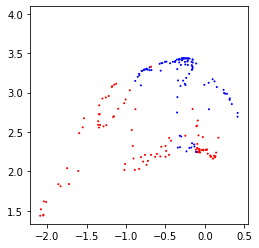

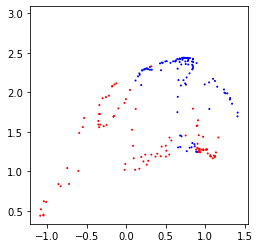

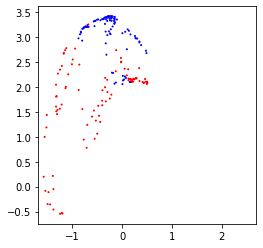

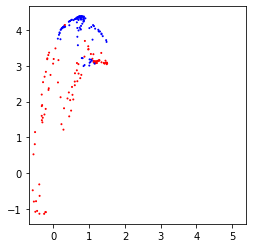

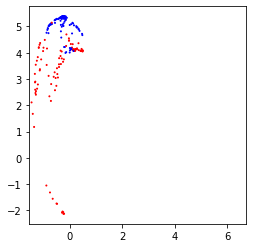

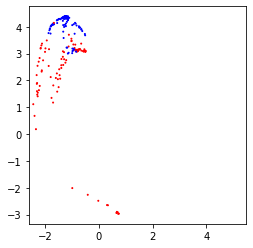

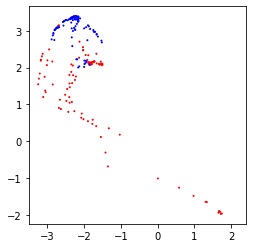

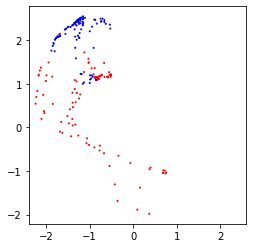

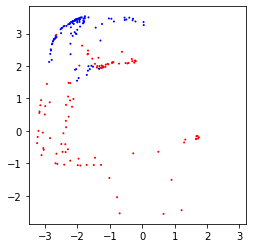

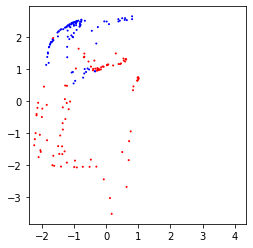

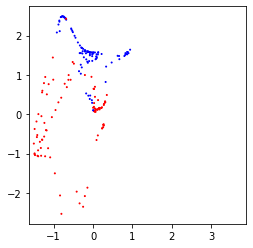

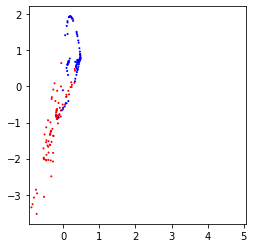

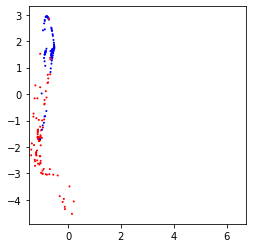

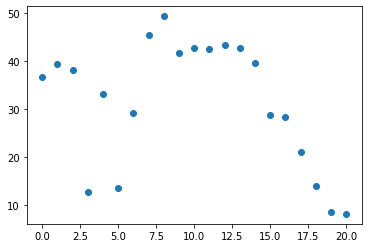

<Figure size 432x288 with 0 Axes>

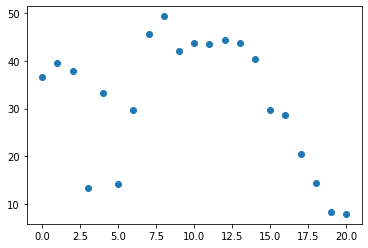

<Figure size 432x288 with 0 Axes>

In [112]:
C_1 = labels_1 * 1
C_2 = labels_2 * 1

plot_progression(Y_k_final, C_1)
plot_progression(Y_k_final2, C_2)

def plotJ(J_liste):
    x_akse = np.arange(len(J_liste))
    plt.scatter(x_akse, J_liste)
    plt.figure(10)
    plt.show()

plotJ(J_list1)
plotJ(J_list2)
    